# IMPORTS

In [1]:
from matplotlib import pyplot as plt
import random
import itertools
from keras.datasets import mnist
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import time
import warnings
import numpy as np
import scipy.io as sio

warnings.filterwarnings('ignore')

# SASVI

In [2]:
def get_a(lambda1, θ1star):
    return(-θ1star+y/lambda1)

def get_b(lambda2, θ1star):
    return(-θ1star+y/lambda2)

def x_ort(x,a,b):
    return(x-np.outer(a,np.dot(x.T,a))/(np.linalg.norm(a)**2))

def y_ort(y,a,b):
    return(y-a*np.dot(y,a)/(np.linalg.norm(a)**2))

In [3]:
def sasvi(X,a,b,λ1,λ2, θ1star, Xort, yort, p):
    tol=10^(-9)

    normX = np.linalg.norm(X,axis=0)
    normb = np.linalg.norm(b)
    Xtb = np.dot(X.T,b)
    Xttheta = np.dot(X.T,θ1star)

    if((np.linalg.norm(a)/float(a.size)) < tol):

        Xta = np.dot(X.T,a)
        norma = np.linalg.norm(a)

        bool_vec=(np.any(a)!=0 and np.dot(b,a)/(normb*norma)>np.abs(Xta)/normX*norma)
        uplus=bool_vec*Xttheta+(1/λ2-1/λ1)/2*(np.linalg.norm(Xort,axis=0)*np.linalg.norm(yort)+np.dot(Xort.T,yort))
        uminus=bool_vec*(-Xttheta)+(1/λ2-1/λ1)/2*(np.linalg.norm(Xort,axis=0)*np.linalg.norm(yort)-np.dot(Xort.T,yort))

        bool_vec=(((Xta >0) & (np.dot(b,a)/(normb*norma)<=Xta/normX*norma)))
        uminus+=bool_vec*(-Xttheta+1/2*(normX*normb-Xtb))

        bool_vec=(((Xta<0) & (np.dot(b,a)/(normb*norma)<=-Xta/normX*norma)))
        uplus+=bool_vec*(Xttheta+1/2*(normX*normb+Xtb))

    else:
        uminus=(-Xttheta+1/2*(normX*normb-Xtb))
        uplus=(Xttheta+1/2*(normX*normb+Xtb))
        
    
    return(np.where((uplus<1-tol) & (uminus<1-tol)))





# Other screening rules

In [4]:
def strong_rule(X,y,theta_before, lamb, lamb_before):
    tol = 10^(-32)
    return np.where(((lamb_before/lamb)*np.abs(np.dot(X.T,theta_before)) + ((lamb_before/lamb) -1))<1-tol)

def safe_screening(X,y,theta_before, lamb, lamb_before):
    tol = 10^(-9)
    s_star = np.max([np.min([np.dot(theta_before.T,y)/(lamb*np.linalg.norm(theta_before)),1]),-1])
    return np.where((np.abs(np.dot(X.T,y))/lamb + np.linalg.norm(X,axis=0)*np.linalg.norm(s_star*theta_before-y/lamb))<1-tol)

def safe_screening2(X,y,theta_before, lamb, lamb_before,lmax):
    tol = 10^(-9)
    lhs = np.abs(X.T.dot(y))
    rhs = lamb - np.linalg.norm(X,axis=0) * np.linalg.norm(y) * (lmax - lamb)/lmax 
    inds = np.where(lhs < rhs - tol)
    return inds

# Functions to compare methods and plot the comparison

In [6]:
def test_method(X,y,λ,λ_max, verbose=False):
    p=len(X[1,:])
    β=np.zeros(X.shape[1])


    Tsasvi=[]
    Tnormal=[]
    Tstrong=[]
    Tsafe=[]


    nb_removed_sasvi=[]
    nb_removed_strong=[]
    nb_removed_safe=[]



    for i in range(len(λ)-1):
        if(verbose):
            print("#### Step n°{}/{} ####".format(i+1,len(λ)-1))

        θ1star=(y-np.dot(X,β))/λ[i]
        a=get_a(λ[i], θ1star)
        b=get_b(λ[i+1], θ1star)
        yort=y_ort(y,a,b)
        Xort=x_ort(X,a,b)
        
        #SASVI SCREENING AND FITTING
        start=time.time()
        to_drop_sasvi1=sasvi(X,a,b,λ[i],λ[i+1], θ1star, Xort,yort, p)
        tmp_time=(time.time()-start)

        X_sasvi = np.delete(X, to_drop_sasvi1, 1)
        nb_removed_sasvi.append(np.shape(to_drop_sasvi1)[1])
        if(verbose):
            print("Number of variables removed with sasvi :",np.shape(to_drop_sasvi1)[1])

        start=time.time()
        if X_sasvi.shape[1] != 0:
            clf = linear_model.Lasso(alpha=λ[i+1]/X.shape[0])
            clf.fit(X_sasvi,y)
        Tsasvi.append(tmp_time+time.time()-start)

        #STRONG RULE SCREENING AND FITTING
        to_drop_strong1=strong_rule(X,y,θ1star, λ[i+1], λ[i])
        X_strong = np.delete(X, to_drop_strong1, 1)
        nb_removed_strong.append(np.shape(to_drop_strong1)[1])
        if(verbose):
            print("Number of variables removed with strong rule :",np.shape(to_drop_strong1)[1])

        start=time.time()
        if X_strong.shape[1] != 0:
            clf = linear_model.Lasso(alpha=λ[i+1]/X.shape[0])
            clf.fit(X_strong,y)
        Tstrong.append(time.time()-start)

        #SAFE RULE SCREENING AND FITTING
        to_drop_safe1=safe_screening(X,y,θ1star, λ[i+1], λ[i])
        # to_drop_safe1=safe_screening2(X,y,θ1star, λ[i+1], λ[i],λ[0])
        X_safe = np.delete(X, to_drop_safe1, 1)
        nb_removed_safe.append(np.shape(to_drop_safe1)[1])
        if(verbose):
            print("Number of variables removed with safe rule :",np.shape(to_drop_safe1)[1])

        start=time.time()
        if X_safe.shape[1] != 0:
            clf = linear_model.Lasso(alpha=λ[i+1]/X.shape[0])
            clf.fit(X_safe,y)
        Tsafe.append(time.time()-start)


        #NO SCREENING FITTING  
        start=time.time()
        clf = linear_model.Lasso(alpha=λ[i+1]/X.shape[0])
        clf.fit(X,y)
        Tnormal.append(time.time()-start)
        β=clf.coef_
        
    return(Tsasvi,Tnormal,Tstrong,Tsafe,nb_removed_sasvi,nb_removed_strong,nb_removed_safe)

In [7]:
def plot_res(Tsasvi,Tnormal,Tstrong,Tsafe,nb_removed_sasvi,nb_removed_strong,nb_removed_safe, λ, λ_max, p):

    plt.figure(figsize=(12,8))
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,Tnormal,label='Normal')
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,Tsasvi,label='Sasvi')
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,Tstrong,label='Strong')
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,Tsafe,label='Safe')
    plt.legend()
    plt.xlabel("λ/λ_max")
    plt.ylabel("Time")
    plt.title("Time to compute as a function of λ/λ_max")

    plt.figure(figsize=(12,8))
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,np.array(nb_removed_sasvi)/p,label='Sasvi')
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,np.array(nb_removed_strong)/p,label='Strong')
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,np.array(nb_removed_safe)/p,label='Safe')
    plt.legend()
    plt.xlabel("λ/λ_max")
    plt.ylabel("Nb removed/Total nb of variables")
    plt.title("Proportion of removed variables as a function of λ/λ_max")

# MNIST example

In [8]:
def gen_data_MNIST():
    (train_X, train_y), (test_X, test_y) = mnist.load_data()
    ind=[[]]*10
    for i in range(10):
        ind[i]=random.sample([j for j in range(np.shape(train_X)[0]) if train_y[j]==i],5000)
    ind=list(itertools.chain.from_iterable(ind))
    X=np.zeros([784,50000])
    for i in range(50000):
        X[:,i]=train_X[ind[i]].flatten()
    y=test_X[random.sample(range(np.shape(test_y)[0]),1)[0]].flatten()
    return(X,y)

In [9]:
[X,y]=gen_data_MNIST()
p=len(X[1,:])
λ_max=np.max(np.abs(np.dot(y,X)))
λ=np.linspace(1,0.05,20)*λ_max

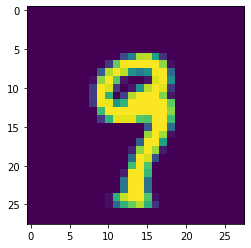

In [111]:
plt.imshow(y.reshape(28,28))

In [10]:
Tsasvi,Tnormal,Tstrong,Tsafe,nb_removed_sasvi,nb_removed_strong,nb_removed_safe=test_method(X,y, λ, λ_max,True)
plot_res(Tsasvi,Tnormal,Tstrong,Tsafe,nb_removed_sasvi,nb_removed_strong,nb_removed_safe,λ, λ_max,p)

#### Step n°1/19 ####
Number of variables removed with sasvi : 50000
Number of variables removed with strong rule : 50000
Number of variables removed with safe rule : 50000
#### Step n°2/19 ####
Number of variables removed with sasvi : 50000
Number of variables removed with strong rule : 50000
Number of variables removed with safe rule : 50000
#### Step n°3/19 ####
Number of variables removed with sasvi : 50000
Number of variables removed with strong rule : 50000
Number of variables removed with safe rule : 50000
#### Step n°4/19 ####


KeyboardInterrupt: 

# PIE Face Image Data Set

In [8]:
def gen_data_PIE():
    list_files = ["data/PIE/PIE05.mat","data/PIE/PIE07.mat","data/PIE/PIE09.mat","data/PIE/PIE27.mat","data/PIE/PIE29.mat"]
    X = np.zeros((1024,11554))
    rows = 0
    for files in list_files:
        content = sio.loadmat(files)
        x = content['fea']
        X[:,rows:(rows+x.shape[0])] = x.T
        rows += x.shape[0]
    indy = random.sample(range(11554),1)
    y = X[:,indy].reshape(-1)
    X = np.delete(X, indy, 1)

    return (X,y)

In [18]:
[X,y]=gen_data_PIE()
p=len(X[1,:])
λ_max=np.max(np.abs(np.dot(y,X)))
λ=np.linspace(1,0.05,20)*λ_max

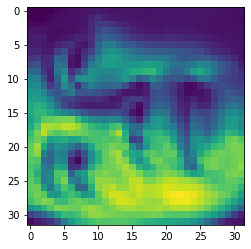

In [10]:
plt.imshow(y.reshape(32,32))

In [26]:
Tsasvi,Tnormal,Tstrong,Tsafe,nb_removed_sasvi,nb_removed_strong,nb_removed_safe=test_method(X,y, λ, λ_max,True)
plot_res(Tsasvi,Tnormal,Tstrong,Tsafe,nb_removed_sasvi,nb_removed_strong,nb_removed_safe,λ, λ_max,p)

#### Step n°1/19 ####
Number of variables removed with sasvi : 11553
Number of variables removed with strong rule : 11553
0.04140028099769021


AxisError: axis 1 is out of bounds for array of dimension 0

#### Step n°1/39 ####
True
Number of variables removed with sasvi : 11553
Number of variables removed with strong rule : 11553
Number of variables removed with safe rule : 11553
#### Step n°2/39 ####
True
Number of variables removed with sasvi : 11553
Number of variables removed with strong rule : 11553
Number of variables removed with safe rule : 11553
#### Step n°3/39 ####
True
Number of variables removed with sasvi : 11553
Number of variables removed with strong rule : 11553
Number of variables removed with safe rule : 11553
#### Step n°4/39 ####
True
Number of variables removed with sasvi : 11553
Number of variables removed with strong rule : 11553
Number of variables removed with safe rule : 11553
#### Step n°5/39 ####
True
Number of variables removed with sasvi : 11553
Number of variables removed with strong rule : 11553
Number of variables removed with safe rule : 11553
#### Step n°6/39 ####
True
Number of variables removed with sasvi : 11553
Number of variables removed with str

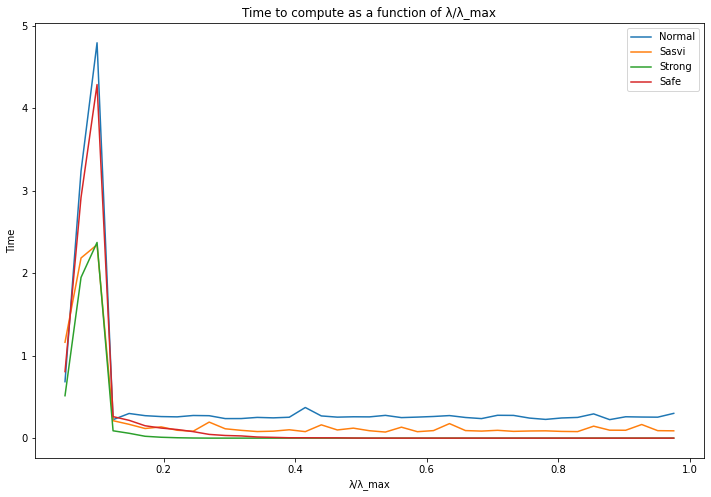

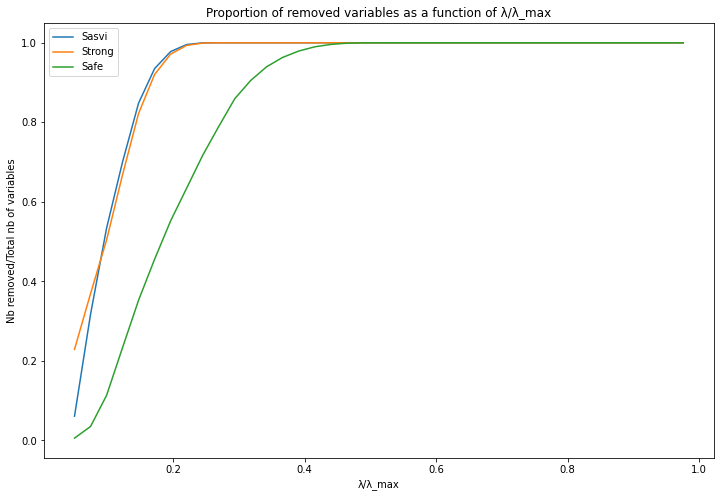

In [10]:
Tsasvi,Tnormal,Tstrong,Tsafe,nb_removed_sasvi,nb_removed_strong,nb_removed_safe=test_method(X,y, λ, λ_max,True)
plot_res(Tsasvi,Tnormal,Tstrong,Tsafe,nb_removed_sasvi,nb_removed_strong,nb_removed_safe,λ, λ_max,p)